<H1>Question: How do seatbelt usage, seating position, and vehicle type relate to injury outcomes?</H1>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
import numpy as np

<H2>Preprocessing<H2>

In [2]:
def check_missing_values(df):
    """
    Plot and display a bar chart showing count of missing values per column.
    - Always prints chart, even if all columns are complete.
    - Y axis starts from 0 and uses integer ticks.
    - Bars are labeled with their count.
    """
    missing_count = df.isna().sum()
    sorted_missing = missing_count.sort_values(ascending=False)

    ax = sorted_missing.plot(kind='bar', color='salmon', edgecolor='black')

    plt.title("Missing Values Count")
    plt.ylabel("Count")
    plt.xlabel("Column")
    plt.xticks(rotation=45)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Y axis as integer

    max_val = sorted_missing.max()
    # set Y axis limit to 10% more than max value
    plt.ylim(0, max_val * 1.1 if max_val > 0 else 1)

    # Add value labels above bars
    for i, percent in enumerate(sorted_missing):
        if percent > 0:
            y = percent + 0.5
        else:
            y = 0.2

        label = f"{percent}"
        ax.text(i, y, label, ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


def plot_class_distributions(df):
    """
    Generate a 2x2 figure with pie charts for:
    INJ_LEVEL, HELMET_BELT_WORN, SEATING_POSITION, and VEHICLE_TYPE.
    Displays count and percentage in the legend instead of on the pie.
    Saves the figure to 'output/class_distributions.png'.
    """

    features = ["INJ_LEVEL", "SEATBELT", "SEATING_POSITION", "VEHICLE_TYPE"]
    titles = {
        "INJ_LEVEL": "Injury Level",
        "SEATBELT": "Seatbelt Worn",
        "SEATING_POSITION": "Seating Position",
        "VEHICLE_TYPE": "Vehicle Type"
    }

    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    axs = axs.flatten()
    cmap = plt.get_cmap('tab20')

    for i, feature in enumerate(features):
        counts = df[feature].value_counts()
        values = counts.values
        total = values.sum()
        labels = counts.index.astype(str)

        # Generate colors for each category
        colors = cmap(range(len(labels)))

        # Create legend labels with percentage and count
        legend_labels = [
            f"{label} - {count / total * 100:.1f}% ({count})"
            for label, count in zip(labels, values)
        ]

        # Pie chart
        wedges, texts = axs[i].pie(
            values,
            labels=None,
            startangle=140,
            colors=colors
        )

        axs[i].set_title(titles[feature], fontsize=14)

        # Add legend
        axs[i].legend(
            wedges,
            legend_labels,
            title="Category Distribution",
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            fontsize=10
        )

    plt.tight_layout()
    plt.show()

def filtering(df):

    # Remove invalid HELMET_BELT_WORN entries
    df = df[df["SEATBELT"].isin([1.0, 2.0])]

    # Remove NA and NK from SEATING_POSITION
    df = df[~df["SEATING_POSITION"].isin(["NA", "NK"])]

    # Remove invalid INJ_LEVEL entries
    df = df[~df["VEHICLE_TYPE"].isin([18,19])]

    return df


def aggregation(df):

    # Map SEATING_POSITION
    seating_mapping = {
        "D": "Driver",
        "CF": "Front",
        "LF": "Front",
        "CR": "Rear",
        "LR": "Rear",
        "RR": "Rear",
        "OR": "Rear",
        "PS": "Motorcycle",
        "PL": "Motorcycle"
    }
    df.loc[:,"SEATING_POSITION"] = df["SEATING_POSITION"].map(seating_mapping)

    # Delete rows with unmapped SEATING_POSITION
    df = df[df["SEATING_POSITION"].notna()].copy()


    # Map VEHICLE_TYPE
    vehicle_type_mapping = {
        1: "Car", 2: "Car", 3: "Car",
        4: "Truck", 5: "Truck", 6: "Truck", 7: "Truck",
        60: "Truck", 61: "Truck", 62: "Truck", 63: "Truck",
        71: "Truck", 72: "Truck",
        8: "Bus", 9: "Bus",
        10: "Motorcycle", 11: "Motorcycle", 12: "Motorcycle",
        13: "Other", 14: "Other", 15: "Other", 16: "Other",
        17: "Other", 19: "Other", 20: "Other", 27: "Other"
    }
    df.loc[:, "VEHICLE_TYPE"] = df["VEHICLE_TYPE"].map(vehicle_type_mapping)

    # Delete rows with unmapped VEHICLE_TYPE
    df = df[df["VEHICLE_TYPE"].notna()].copy()

    return df


def data_preprocessing():
        
    # Read the datasets
    person_df = pd.read_csv("dataset/person.csv")
    vehicle_df = pd.read_csv("dataset/vehicle.csv")

    # Merge the datasets on ACCIDENT_NO and VEHICLE_ID
    df = pd.merge(person_df, vehicle_df, on=["ACCIDENT_NO", "VEHICLE_ID"], how="inner")

    # Drop duplicates based on ACCIDENT_NO and VEHICLE_ID
    df = df.drop_duplicates(subset=["ACCIDENT_NO", "VEHICLE_ID"])

    # Select relevant columns
    df = df[
        ["ACCIDENT_NO", "VEHICLE_ID",  "INJ_LEVEL", "VEHICLE_TYPE", "SEATING_POSITION", "HELMET_BELT_WORN"]
    ]

    df.rename(columns={"HELMET_BELT_WORN": "SEATBELT"}, inplace=True)

    # Sort by ACCIDENT_NO
    df = df.sort_values(by="ACCIDENT_NO")

    check_missing_values(df)

    # Fill missing values with mode
    df["INJ_LEVEL"].fillna(df["INJ_LEVEL"].mode()[0])
    df["SEATBELT"].fillna(df["SEATBELT"].mode()[0])
    df["SEATING_POSITION"].fillna(df["SEATING_POSITION"].mode()[0])
    df["VEHICLE_TYPE"].fillna(df["VEHICLE_TYPE"].mode()[0])

    # Drop rows with missing values
    df = df.dropna(subset=["ACCIDENT_NO"])
    df = df.dropna(subset=["VEHICLE_ID"])

    df = filtering(df)
    df = aggregation(df)

    plot_class_distributions(df)

    return df.dropna()

def data_preprocessing_2():
        
    # Read the datasets
    person_df = pd.read_csv("dataset/person.csv")
    vehicle_df = pd.read_csv("dataset/vehicle.csv")

    # Merge the datasets on ACCIDENT_NO and VEHICLE_ID
    df = pd.merge(person_df, vehicle_df, on=["ACCIDENT_NO", "VEHICLE_ID"], how="inner")

    # Drop duplicates based on ACCIDENT_NO and VEHICLE_ID
    df = df.drop_duplicates(subset=["ACCIDENT_NO", "VEHICLE_ID"])

    # Drop rows with missing values in INJ_LEVEL
    df = df.dropna(subset=["INJ_LEVEL"])

    # Select relevant columns
    df = df[
        ["ACCIDENT_NO", "VEHICLE_ID",  "INJ_LEVEL", "VEHICLE_TYPE", "SEATING_POSITION", "HELMET_BELT_WORN", "TAKEN_HOSPITAL"]
    ]
    
    df.rename(columns={"HELMET_BELT_WORN": "SEATBELT"}, inplace=True)

    # Sort by ACCIDENT_NO
    df = df.sort_values(by="ACCIDENT_NO")

    check_missing_values(df)

    # Fill missing values with mode
    df["INJ_LEVEL"].fillna(df["INJ_LEVEL"].mode()[0])
    df["SEATBELT"].fillna(df["SEATBELT"].mode()[0])
    df["SEATING_POSITION"].fillna(df["SEATING_POSITION"].mode()[0])
    df["VEHICLE_TYPE"].fillna(df["VEHICLE_TYPE"].mode()[0])

    # Drop rows with missing values
    df = df.dropna(subset=["ACCIDENT_NO"])
    df = df.dropna(subset=["VEHICLE_ID"])

    return df.dropna()

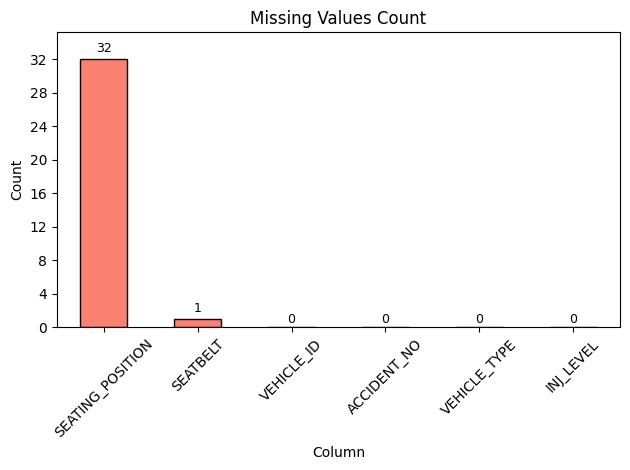

C:\Users\Nobod\AppData\Local\Temp\ipykernel_7004\2350946445.py:140: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Car' 'Car' 'Car' ... 'Car' 'Car' 'Car']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, "VEHICLE_TYPE"] = df["VEHICLE_TYPE"].map(vehicle_type_mapping)


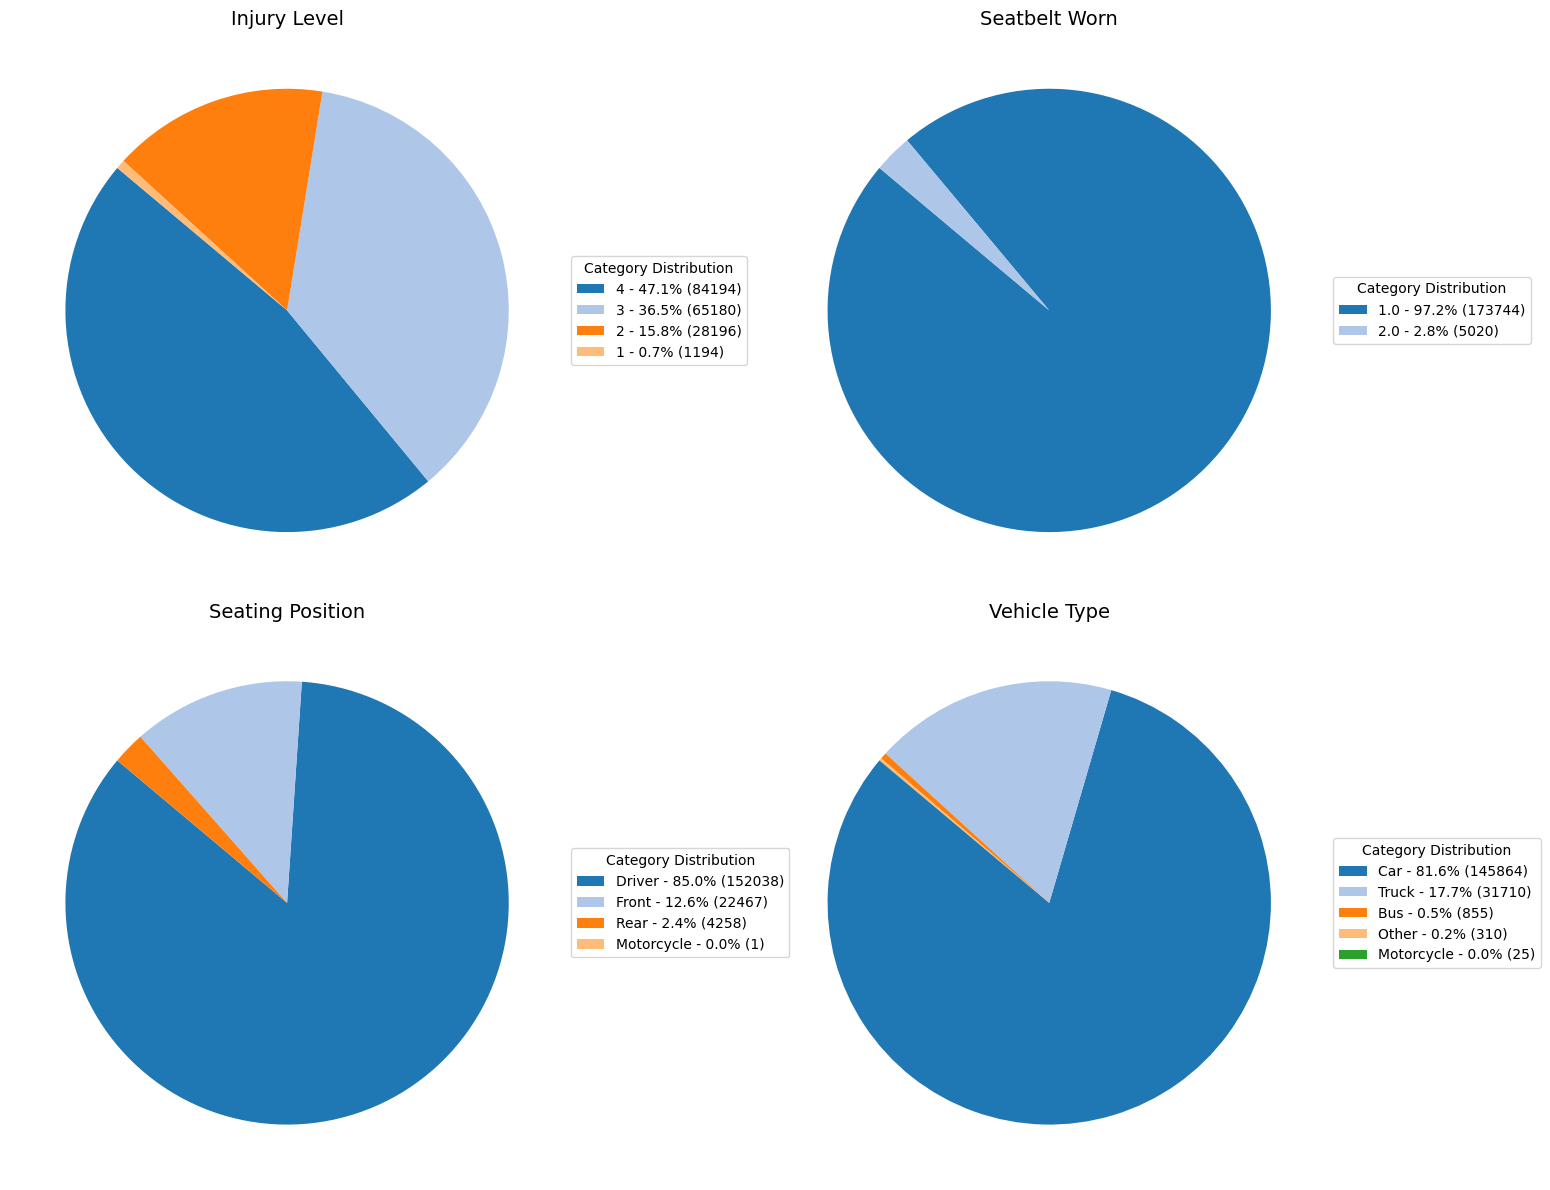

In [3]:
model_df = data_preprocessing()

In [4]:
from scipy.stats import describe
from statistics import median

desc_stats = describe(model_df['INJ_LEVEL'], bias=False)
# Print descriptive statistics
print("Descriptive Statistics:")
print(f"Count: {desc_stats.nobs}")
print(f"Mean: {desc_stats.mean}")
print(f"Median: {median(model_df['INJ_LEVEL'])}")
# Print the minimum and maximum values
print(f"Minimum: {desc_stats.minmax[0]}")
print(f"Maximum: {desc_stats.minmax[1]}")
# Print the skewness
print(f"Skewness: {desc_stats.skewness}")


Descriptive Statistics:
Count: 178764
Mean: 3.2998925958246628
Median: 3.0
Minimum: 1
Maximum: 4
Skewness: -0.6488386625523943


In [5]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
le = LabelEncoder()
model_df['SEATING_POSITION'] = le.fit_transform(model_df['SEATING_POSITION'])
model_df['VEHICLE_TYPE'] = le.fit_transform(model_df['VEHICLE_TYPE'])
model_df['INJ_LEVEL'] = le.fit_transform(model_df['INJ_LEVEL'])
model_df['SEATBELT'] = le.fit_transform(model_df['SEATBELT'])

model_df

,ACCIDENT_NO,VEHICLE_ID,INJ_LEVEL,VEHICLE_TYPE,SEATING_POSITION,SEATBELT
315841,T20120000009,A,2,1,1,0
339156,T20120000012,B,1,1,0,0
315858,T20120000013,A,1,1,0,0
46297,T20120000018,A,2,1,0,0
312377,T20120000021,A,2,1,0,0
...,...,...,...,...,...,...
355236,T20250006861,C,2,1,0,0
377824,T20250006861,A,3,4,0,0
375171,T20250006861,B,3,1,0,0
56,T20250007521,A,2,1,0,0


<H2>Correlation and Causal Analysis Component<H2>

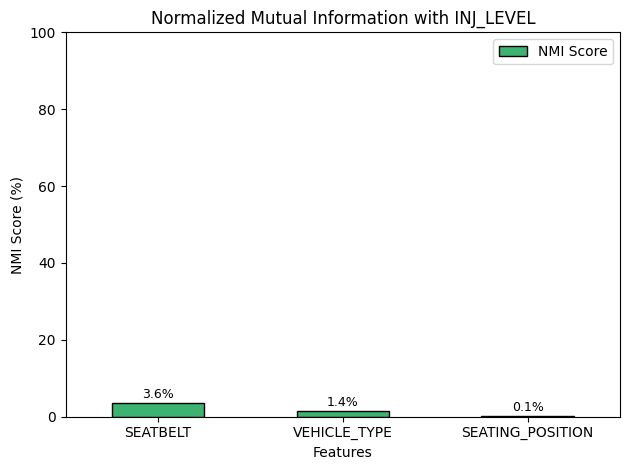

In [6]:
def compute_probability(col):
    """
    Compute the probability of a certain event
    """
    return col.value_counts() / len(col)

def compute_entropy(col):
    """
    Compute the entropy of a certain event
    """
    probabilities = compute_probability(col)
    entropy = -sum(probabilities * np.log2(probabilities))
    return entropy

def compute_conditional_entropy(x, y):
    """
    Compute the conditional entropy between two random variables.
    Specifically, the conditional entropy of Y given X.
    """
    probability_x = compute_probability(x)
    
    temp_df = pd.DataFrame({'X': x, 'Y': y})
    
    entropy_by_group = temp_df.groupby('X')['Y'].aggregate(compute_entropy)
    conditional_entropy = sum(probability_x * entropy_by_group)
    
    return conditional_entropy

def NMI(x, y):
    """
    Compute the NMI between two random variables
    """
    # H(X) and H(Y)
    entropy_x = compute_entropy(x)
    entropy_y = compute_entropy(y)
    
    # H(Y|X)
    conditional_entropy = compute_conditional_entropy(x, y)
    
    # MI(X, Y)
    MI = entropy_y - conditional_entropy 
    
    normalized = MI / min(entropy_x, entropy_y)
    return round(normalized * 100, 2)  # Convert to percentage

def correlation_analysis():

    cleaned_data = model_df

    # select features and target variable
    features = ["SEATING_POSITION", "SEATBELT", "VEHICLE_TYPE"]
    target = "INJ_LEVEL"

    # store Normalized Mutual Information (NMI) results
    results = {}
    for feature in features:
        results[feature] = NMI(cleaned_data[feature], cleaned_data[target])

    # convert results to DataFrame for better visualization
    nmi_df = pd.DataFrame(list(results.items()), columns=["Feature", "NMI Score"])
    nmi_df = nmi_df.sort_values(by="NMI Score", ascending=False)
    
    ax = nmi_df.plot(kind='bar',  x='Feature', y='NMI Score', color='mediumseagreen', edgecolor='black')
    
    # Add value labels above bars
    for i, percent in enumerate(nmi_df["NMI Score"]):
        if percent > 0:
            y = percent + 0.5
        else:
            y = 0.2

        label = f"{percent:.1f}%"
        ax.text(i, y, label, ha='center', va='bottom', fontsize=9)

    # plotting
    plt.title("Normalized Mutual Information with INJ_LEVEL")
    plt.ylabel("NMI Score (%)")
    plt.xlabel("Features")
    plt.xticks(rotation=0)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

correlation_analysis()


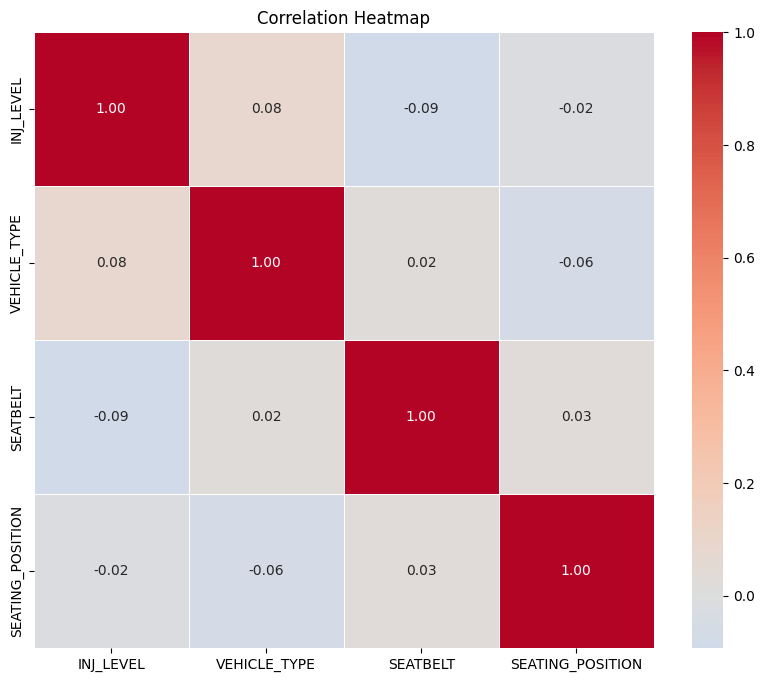

In [7]:
# Plot correlation heatmap variables vs. inj_level
# Only plot the INJ_LEVEL column
plt.figure(figsize=(10, 8))
sns.heatmap(model_df[['INJ_LEVEL', 'VEHICLE_TYPE', 'SEATBELT', 'SEATING_POSITION']].corr(), annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

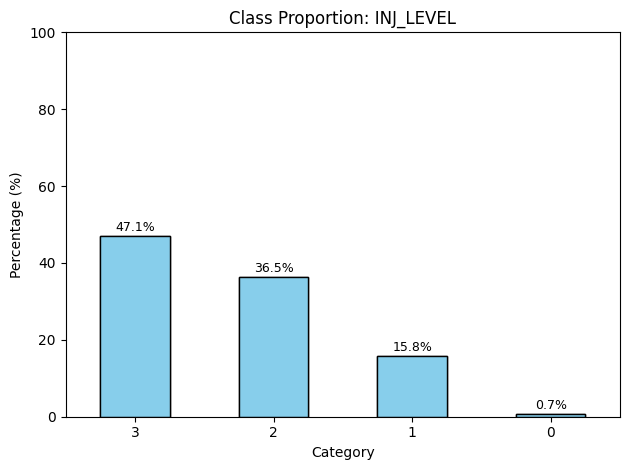

In [8]:
def check_class_distribution(df, column):
    """
    Plot and save a bar chart showing class proportion of a given column.
    """
    proportions = (df[column].value_counts(normalize=True) * 100).round(2)
    sorted_proportions = proportions.sort_values(ascending=False)

    ax = sorted_proportions.plot(kind='bar', color='salmon', edgecolor='black')
    
    proportions.plot(kind='bar', color='skyblue', edgecolor='black')
    
    # Add value labels above bars
    for i, percent in enumerate(sorted_proportions):
        if percent > 0:
            y = percent + 0.5
        else:
            y = 0.2

        label = f"{percent:.1f}%"
        ax.text(i, y, label, ha='center', va='bottom', fontsize=9)
        
    plt.title(f"Class Proportion: {column}")
    plt.ylabel("Percentage (%)")
    plt.xlabel("Category")
    plt.ylim(0, 100)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

check_class_distribution(model_df,"INJ_LEVEL")

<H2>Supervised Learning Models and Evaluation Component<H2>

In [9]:
# Define the features and target variable
from sklearn.model_selection import train_test_split
ind_var_1 = [
    'VEHICLE_TYPE',
    'SEATING_POSITION',
    'SEATBELT',
]

<H3> Logistic Regression </H3>

Default Parameters: {'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy (without grid search): 0.41
Accuracy (with grid search): 0.46


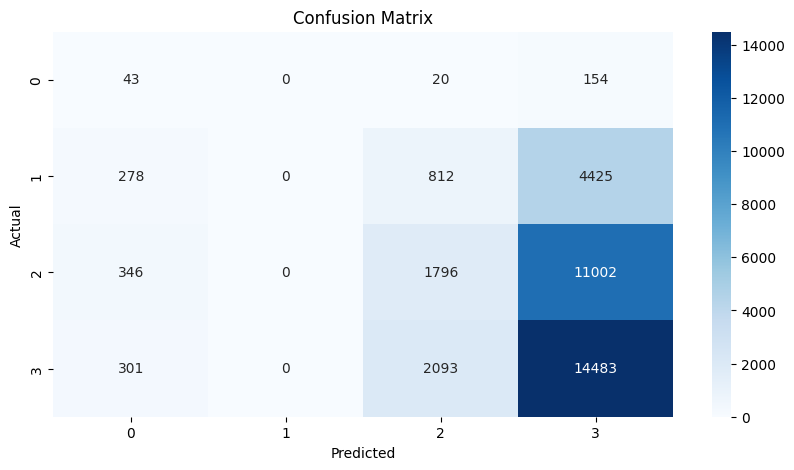

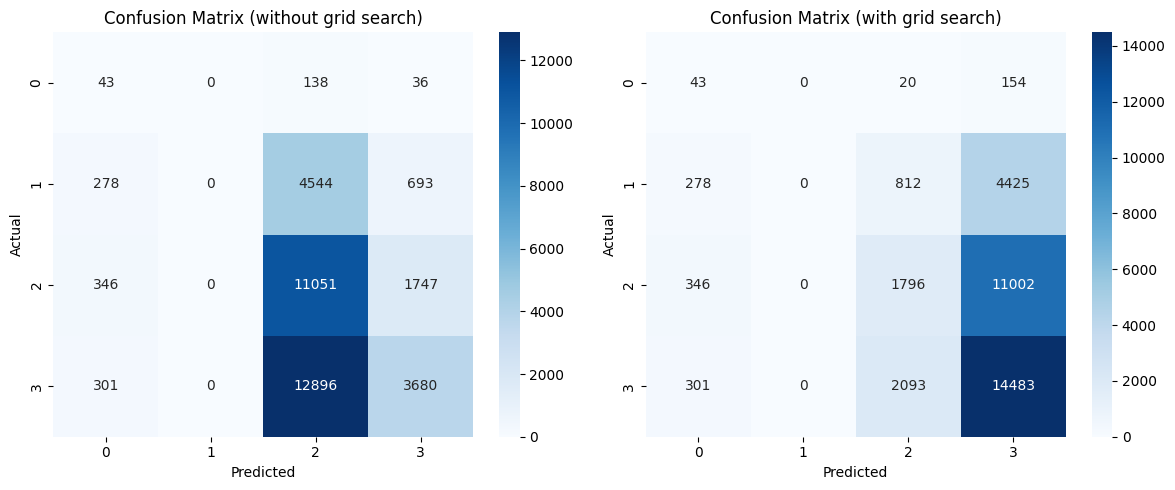

Classification Report (without grid search):
              precision    recall  f1-score   support

           0       0.04      0.20      0.07       217
           1       0.00      0.00      0.00      5515
           2       0.39      0.84      0.53     13144
           3       0.60      0.22      0.32     16877

    accuracy                           0.41     35753
   macro avg       0.26      0.31      0.23     35753
weighted avg       0.42      0.41      0.35     35753

Classification Report (with grid search):
              precision    recall  f1-score   support

           0       0.04      0.20      0.07       217
           1       0.00      0.00      0.00      5515
           2       0.38      0.14      0.20     13144
           3       0.48      0.86      0.62     16877

    accuracy                           0.46     35753
   macro avg       0.23      0.30      0.22     35753
weighted avg       0.37      0.46      0.37     35753



d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Python\Lib\site-packages\s

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

def model_pipeline_lr(X_train, y_train, X_test, y_test):
    # Create a logistic regression model
    model = LogisticRegression(class_weight='balanced')
    # Define hyperparameter grid
    param_grid = {
        'C': [0.01, 0.1, 1, 10],             
        'penalty': ['l1', 'l2'],             
        'solver': ['liblinear', 'saga']     
    }

    # Perform grid search with 5-fold cross-validation
    model.fit(X_train, y_train)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model from grid search
    best_model = grid_search.best_estimator_
    print(f'Default Parameters: {model.get_params()}')
    print("Best Parameters:", grid_search.best_params_)

    # Make predictions
    y_pred_0 = model.predict(X_test)
    y_pred = best_model.predict(X_test)

    # Accuracy score
    accuracy_0 = accuracy_score(y_test, y_pred_0)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy (without grid search): {accuracy_0:.2f}")
    print(f"Accuracy (with grid search): {accuracy:.2f}")

    # Confusion matrix plot side by side
    cm0 = confusion_matrix(y_test, y_pred_0)
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot cm on a separate figure
    plt.figure(figsize=(10, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot confusion matrices side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm0, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix (without grid search)')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title('Confusion Matrix (with grid search)')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    # Classification report
    print("Classification Report (without grid search):")
    print(classification_report(y_test, y_pred_0))
    print("Classification Report (with grid search):")
    print(classification_report(y_test, y_pred))
# Define initial train test sets
X = model_df[ind_var_1]
y = model_df['INJ_LEVEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_pipeline_lr(X_train, y_train, X_test, y_test)

<H3> KNN <H3>

Default Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Accuracy (without grid search): 0.46
Accuracy (with grid search): 0.47


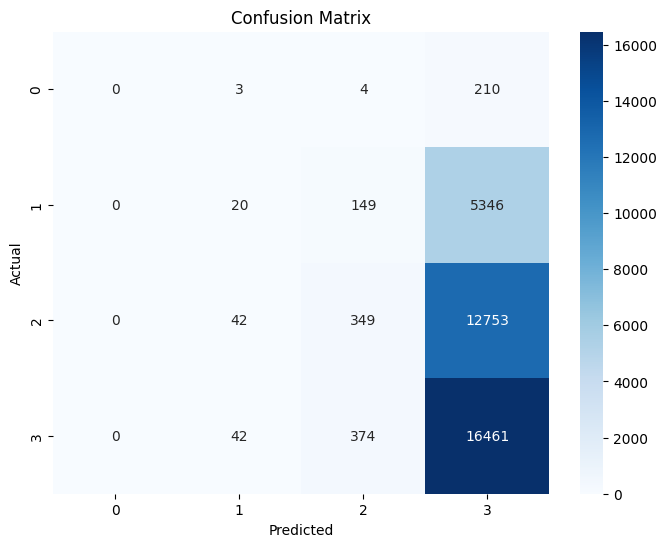

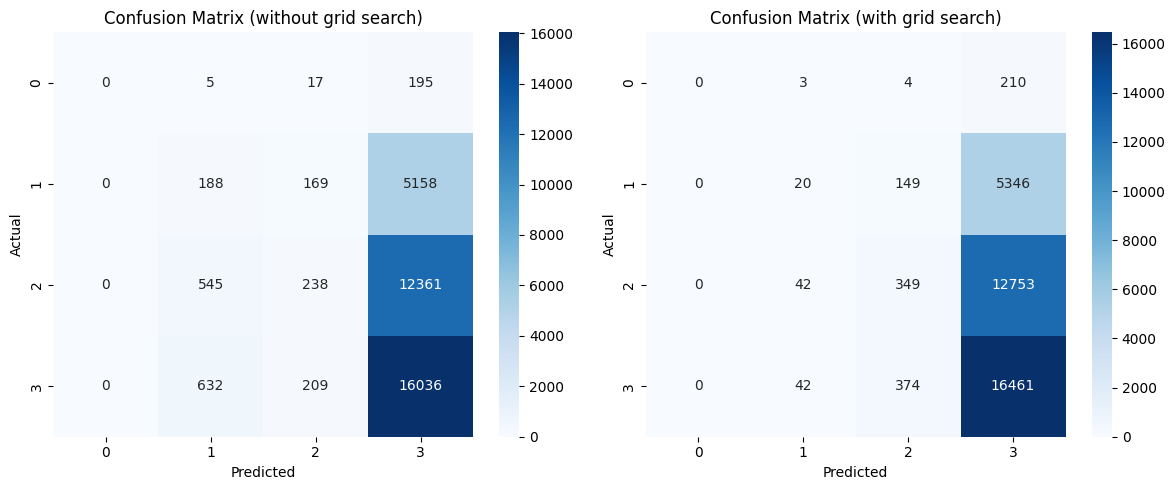

Classification Report (without grid search):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       217
           1       0.14      0.03      0.05      5515
           2       0.38      0.02      0.03     13144
           3       0.48      0.95      0.63     16877

    accuracy                           0.46     35753
   macro avg       0.25      0.25      0.18     35753
weighted avg       0.38      0.46      0.32     35753

Classification Report (with grid search):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       217
           1       0.19      0.00      0.01      5515
           2       0.40      0.03      0.05     13144
           3       0.47      0.98      0.64     16877

    accuracy                           0.47     35753
   macro avg       0.26      0.25      0.17     35753
weighted avg       0.40      0.47      0.32     35753



d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Python\Lib\site-packages\s

KNeighborsClassifier(metric='euclidean', n_neighbors=7, weights='distance')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def model_pipeline_knn(X_train, y_train, X_test, y_test):
    # Define parameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    # Create the KNN classifier
    knn = KNeighborsClassifier()

    # Create GridSearch
    subset_X = X_train.sample(frac=0.1, random_state=42) # Use a subset because of large dataset
    subset_y = y_train.loc[subset_X.index]
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(subset_X, subset_y)

    # Best model
    knn.fit(X_train, y_train)
    y_pred_0 = knn.predict(X_test)
    
    best_knn = grid_search.best_estimator_
    print(f'Default Parameters: {knn.get_params()}')
    print("Best Parameters:", grid_search.best_params_)

    # Predict and evaluate
    y_pred = best_knn.predict(X_test)
    accuracy_0 = accuracy_score(y_test, y_pred_0)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy (without grid search): {accuracy_0:.2f}")
    print(f"Accuracy (with grid search): {accuracy:.2f}")

    # Confusion matrix plot side by side
    cm0 = confusion_matrix(y_test, y_pred_0)
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot cm1 on a separate fig
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot confusion matrices side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm0, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix (without grid search)')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title('Confusion Matrix (with grid search)')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    # Graph the classification report
    print("Classification Report (without grid search):")
    print(classification_report(y_test, y_pred_0))
    print("Classification Report (with grid search):")
    print(classification_report(y_test, y_pred))

    return best_knn

# Define initial train test sets
X = model_df[ind_var_1]
y = model_df['INJ_LEVEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_pipeline_knn(X_train, y_train, X_test, y_test)



<H3> Decision Tree </H3>

Default Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy (without grid search): 0.47
Test Accuracy (with grid search): 0.47


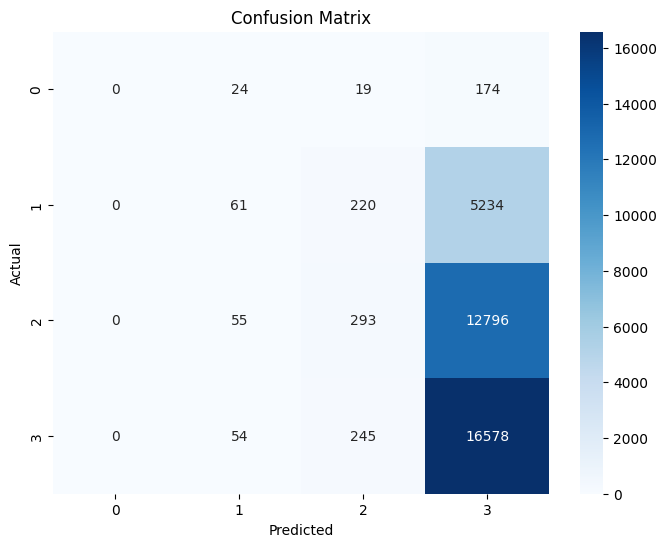

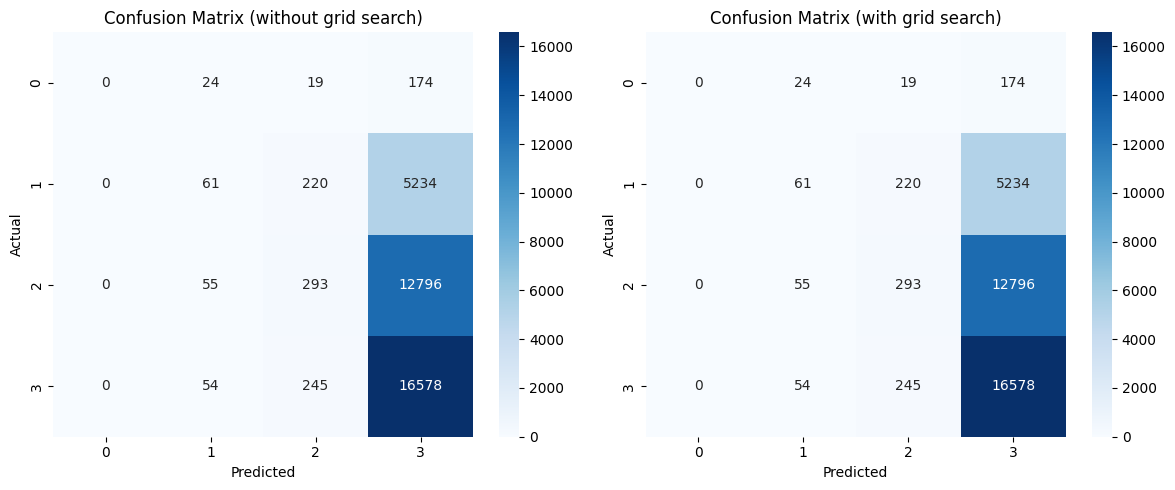

Classification Report (without grid search):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       217
           1       0.31      0.01      0.02      5515
           2       0.38      0.02      0.04     13144
           3       0.48      0.98      0.64     16877

    accuracy                           0.47     35753
   macro avg       0.29      0.25      0.18     35753
weighted avg       0.41      0.47      0.32     35753

Classification Report (with grid search):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       217
           1       0.31      0.01      0.02      5515
           2       0.38      0.02      0.04     13144
           3       0.48      0.98      0.64     16877

    accuracy                           0.47     35753
   macro avg       0.29      0.25      0.18     35753
weighted avg       0.41      0.47      0.32     35753



d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Python\Lib\site-packages\s

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def model_pipeline_dt(X_train, y_train, X_test, y_test):
    # Define the parameter grid
    param_grid = {
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy'] 
    }

    # Initialize the model
    dt = DecisionTreeClassifier(random_state=42)

    # Perform grid search with 5-fold cross-validation
    grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model from grid search
    dt.fit(X_train, y_train)
    best_dt = grid_search.best_estimator_
    print(f'Default Parameters: {dt.get_params()}')
    print(f"Best parameters: {grid_search.best_params_}")

    # Predict on test set
    y_pred_0 = dt.predict(X_test)
    y_pred = best_dt.predict(X_test)

    # Accuracy
    accuracy_0 = accuracy_score(y_test, y_pred_0)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy (without grid search): {accuracy_0:.2f}")
    print(f"Test Accuracy (with grid search): {accuracy:.2f}")

    # Confusion matrix plot side by side
    cm0 = confusion_matrix(y_test, y_pred_0)
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot cm on a separate fig
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot confusion matrices side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm0, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix (without grid search)')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title('Confusion Matrix (with grid search)')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Classification report
    print("Classification Report (without grid search):")
    print(classification_report(y_test, y_pred_0))
    print("Classification Report (with grid search):")
    print(classification_report(y_test, y_pred))    # Define the parameter grid



# Define initial train test sets
X = model_df[ind_var_1]
y = model_df['INJ_LEVEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_pipeline_dt(X_train, y_train, X_test, y_test)


<H2>Further Analysis<H2>

During modelling, we have discovered that there are better variables that have high correlation with injury level, which unsurprisingly happen to be taken_hospital, with a -0.71 correlation, indicating strong linear relationship.

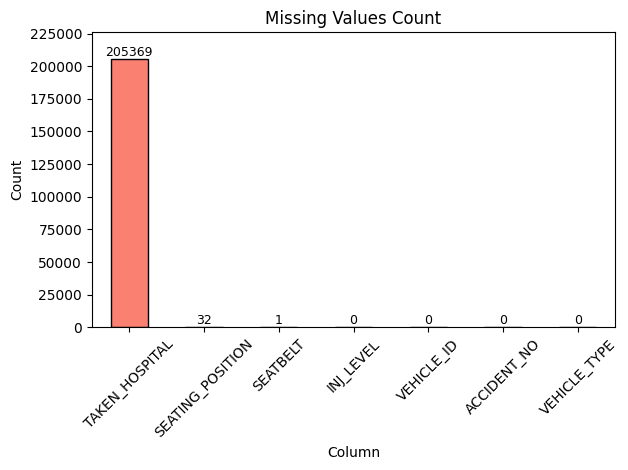

In [13]:
model_df_2 = data_preprocessing_2()
model_df_2['TAKEN_HOSPITAL'] = le.fit_transform(model_df_2['TAKEN_HOSPITAL'])
model_df_2['INJ_LEVEL'] = le.fit_transform(model_df_2['INJ_LEVEL'])
model_df_2['SEATING_POSITION'] = le.fit_transform(model_df_2['SEATING_POSITION'])
model_df_2['VEHICLE_TYPE'] = le.fit_transform(model_df_2['VEHICLE_TYPE'])
model_df_2['SEATBELT'] = le.fit_transform(model_df_2['SEATBELT'])

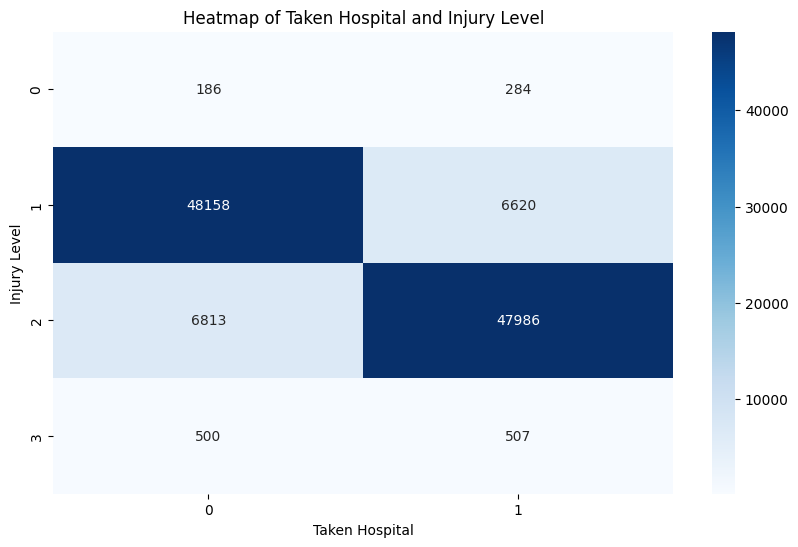

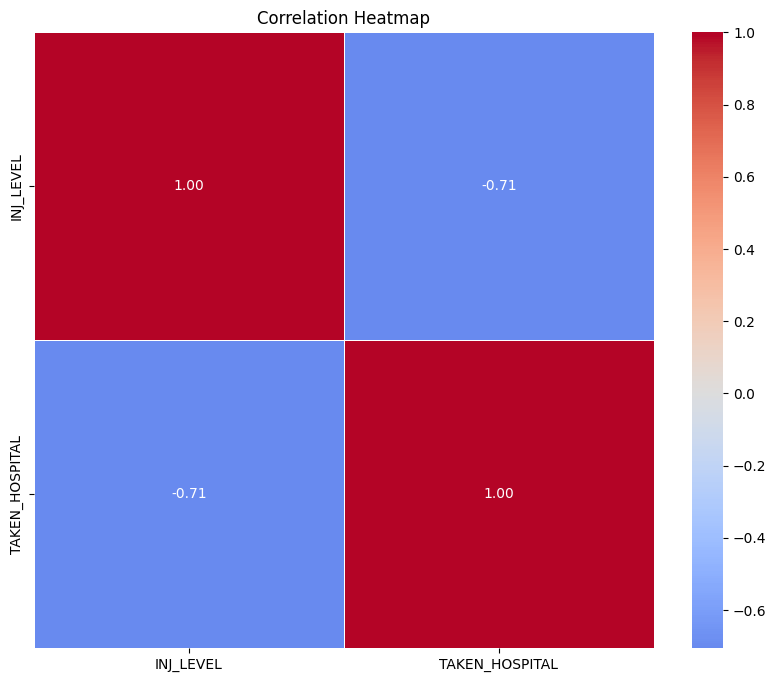

In [14]:
# Heatmap of taken_hospital and inj_level
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab((3 - model_df_2['INJ_LEVEL']), model_df_2['TAKEN_HOSPITAL']), annot=True, fmt='d', cmap='Blues')
plt.title('Heatmap of Taken Hospital and Injury Level')
plt.ylabel('Injury Level')
plt.xlabel('Taken Hospital')
plt.show()

# Correlation heatmap INJ_LEVEL vs. TAKEN_HOSPITAL
plt.figure(figsize=(10, 8))
sns.heatmap(model_df_2[['INJ_LEVEL', 'TAKEN_HOSPITAL']].corr(), annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()



Default Parameters: {'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy (without grid search): 0.86
Accuracy (with grid search): 0.87


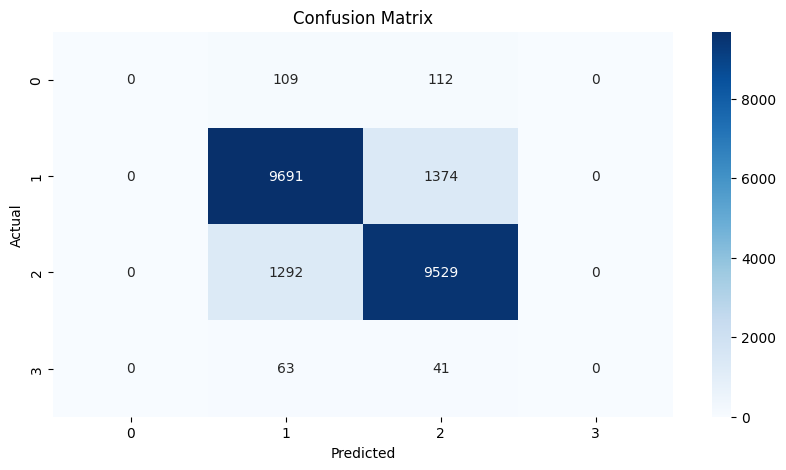

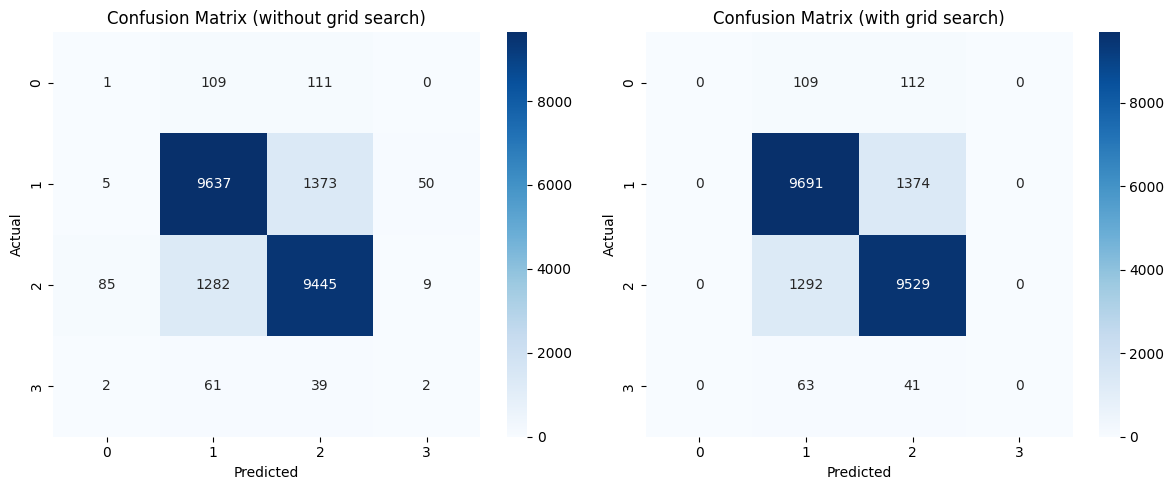

Classification Report (without grid search):
              precision    recall  f1-score   support

           0       0.01      0.00      0.01       221
           1       0.87      0.87      0.87     11065
           2       0.86      0.87      0.87     10821
           3       0.03      0.02      0.02       104

    accuracy                           0.86     22211
   macro avg       0.44      0.44      0.44     22211
weighted avg       0.85      0.86      0.86     22211

Classification Report (with grid search):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       221
           1       0.87      0.88      0.87     11065
           2       0.86      0.88      0.87     10821
           3       0.00      0.00      0.00       104

    accuracy                           0.87     22211
   macro avg       0.43      0.44      0.44     22211
weighted avg       0.85      0.87      0.86     22211



d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Default Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy (without grid search): 0.86
Accuracy (with grid search): 0.86


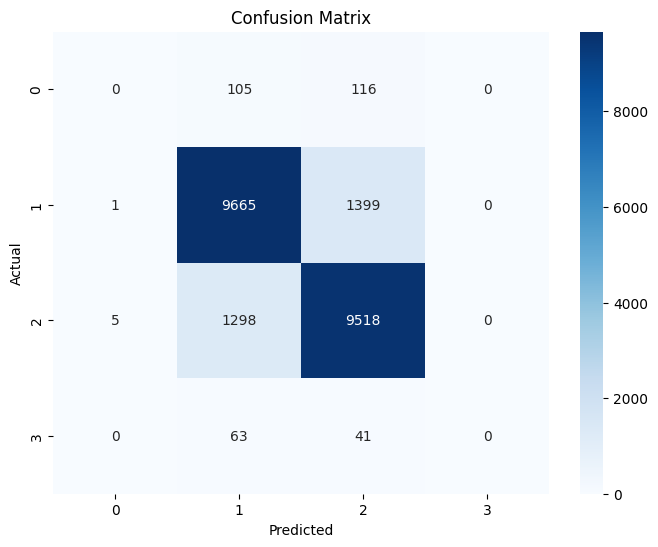

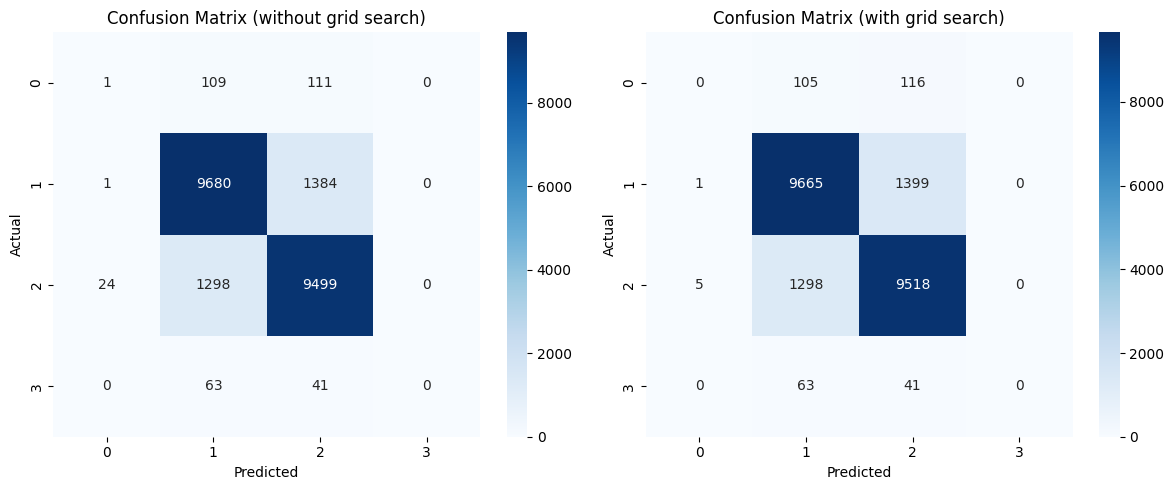

Classification Report (without grid search):
              precision    recall  f1-score   support

           0       0.04      0.00      0.01       221
           1       0.87      0.87      0.87     11065
           2       0.86      0.88      0.87     10821
           3       0.00      0.00      0.00       104

    accuracy                           0.86     22211
   macro avg       0.44      0.44      0.44     22211
weighted avg       0.85      0.86      0.86     22211

Classification Report (with grid search):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       221
           1       0.87      0.87      0.87     11065
           2       0.86      0.88      0.87     10821
           3       0.00      0.00      0.00       104

    accuracy                           0.86     22211
   macro avg       0.43      0.44      0.44     22211
weighted avg       0.85      0.86      0.86     22211



d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Python\Lib\site-packages\s

Default Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy (without grid search): 0.86
Test Accuracy (with grid search): 0.87


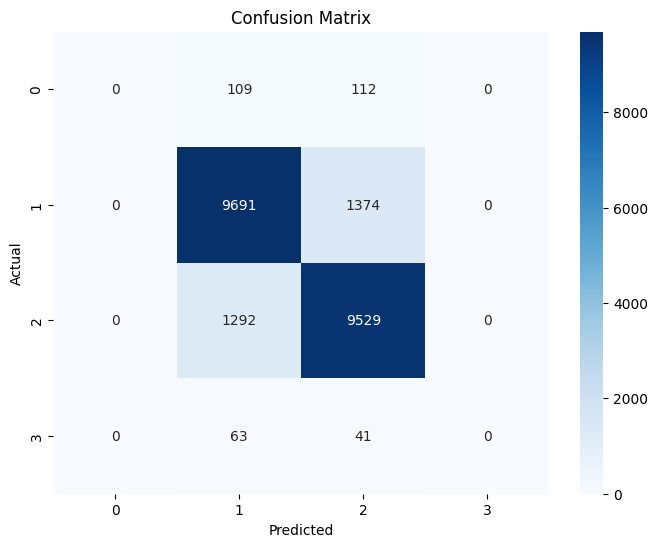

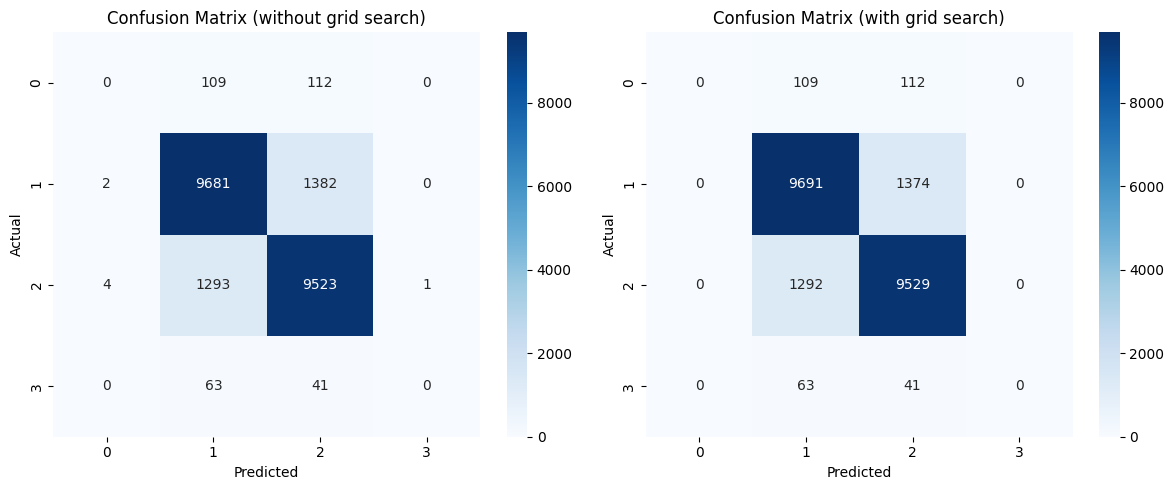

Classification Report (without grid search):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       221
           1       0.87      0.87      0.87     11065
           2       0.86      0.88      0.87     10821
           3       0.00      0.00      0.00       104

    accuracy                           0.86     22211
   macro avg       0.43      0.44      0.44     22211
weighted avg       0.85      0.86      0.86     22211

Classification Report (with grid search):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       221
           1       0.87      0.88      0.87     11065
           2       0.86      0.88      0.87     10821
           3       0.00      0.00      0.00       104

    accuracy                           0.87     22211
   macro avg       0.43      0.44      0.44     22211
weighted avg       0.85      0.87      0.86     22211



d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Program Files\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Define new train test sets
X = model_df_2.drop(columns=['ACCIDENT_NO', 'VEHICLE_ID', 'INJ_LEVEL'])
y = model_df_2['INJ_LEVEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_pipeline_lr(X_train, y_train, X_test, y_test)
model_pipeline_knn(X_train, y_train, X_test, y_test)
model_pipeline_dt(X_train, y_train, X_test, y_test)

All the resulting model show greatly improved accuracy after inserting one more TAKEN_HOSPITAL variable